In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns

import rasterio
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplot
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [3]:
# 477 actual methodology data around CA
ca_broadband = pd.read_csv("./Data/fcc477actual/CA_201906.csv")

# Loading CA census blocks shapefile
# Download from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
ca_shp = gpd.read_file("./Data/shapefiles/censusblocks/ca/tl_2019_06_tabblock10.shp")

# Combining the two into one dataframe
def merge_data(shp,bbnd):
    shp = shp.set_index("GEOID10")
    shp.index = shp.index.map(int)
    
    bbnd = bbnd.set_index("FIPS")
    bbnd.index = bbnd.index.map(int)
    return shp.merge(bbnd,left_index=True, right_index=True, how="inner")

ca_merged = merge_data(ca_shp,ca_broadband)

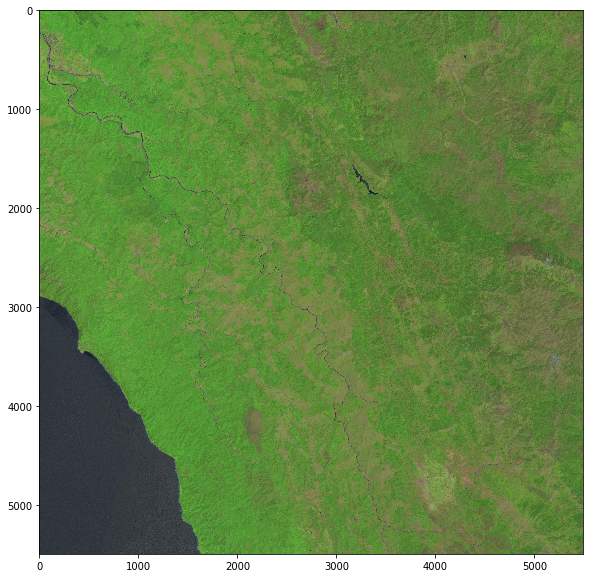

In [4]:
# Displaying the satellite composite image
# These images have RBG channels combined in one file and are smaller resolution compared to raw images
# These composites are ~5mb, while the raw images are ~800mb ... Hopefully the composites work
satimg = rio.open("./Data/sentinel2/ca/composite/T10TDK_composite.tif").read()
pp.figure(figsize=(10,10))
pp.imshow(satimg.transpose([1,2,0]))

In [5]:
# Creating a shape from the satellite image
# This will help us figure out which census block shape files we need to look at
with rasterio.open("./Data/sentinel2/ca/composite/T10TDK_composite.tif") as dataset:

    mask = dataset.dataset_mask()
    sat_trs = dataset.transform
    sat_crs = dataset.crs

    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            rio.features.shapes(mask, transform=dataset.transform)))

# Storing the shape into a dataframe
sat_gdf = gpd.GeoDataFrame.from_features(list(results),crs=sat_crs)

# Making sure the coordinates system matches that used by in the CA census block shapefiles 
sat_gdf = sat_gdf.to_crs(ca_shp.crs)

C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
# Getting the intersection of area covered by the satellite image and the census blocks
sat_ovr = gpd.overlay(sat_gdf,ca_merged)

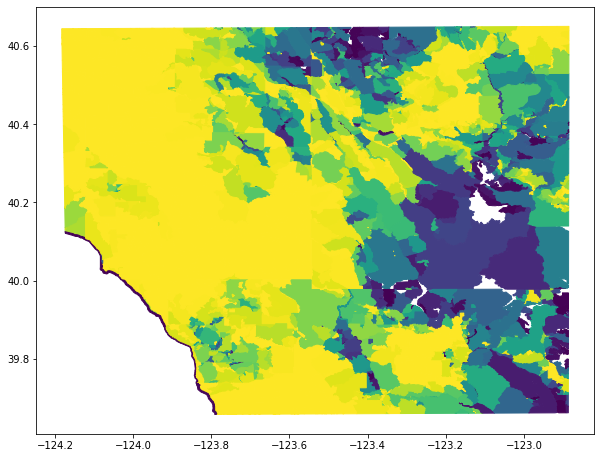

In [7]:
# Plotting 
sat_ovr.plot(column="4G_LTE",edgecolor="face", linewidth=1,figsize=(10,10),cmap="viridis",)

In [8]:
# Rasterizing the shapefiles
sat_ovr = sat_ovr.to_crs(sat_crs)
shapes = [(geom,value) for geom, value in zip(sat_ovr["geometry"],sat_ovr["4G_LTE"])]
raster_4g = rio.features.rasterize(shapes,np.shape(satimg[0]),transform=sat_trs)

C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


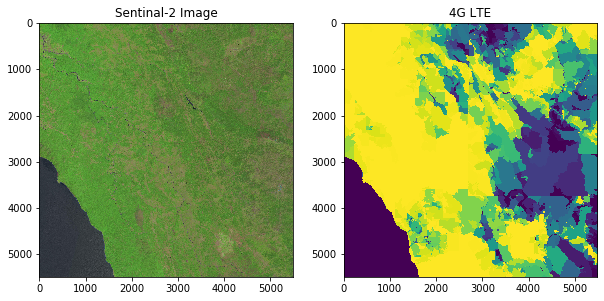

In [13]:
# Making sure the images overlay correctly
pp.figure(figsize=(10,10))
pp.subplot(121)
i=pp.imshow(satimg.transpose([1,2,0]))
pp.title("Sentinal-2 Image")

pp.subplot(122)
pp.title("4G LTE")
j=pp.imshow(raster_4g,alpha=1,cmap="viridis")
pp.show()

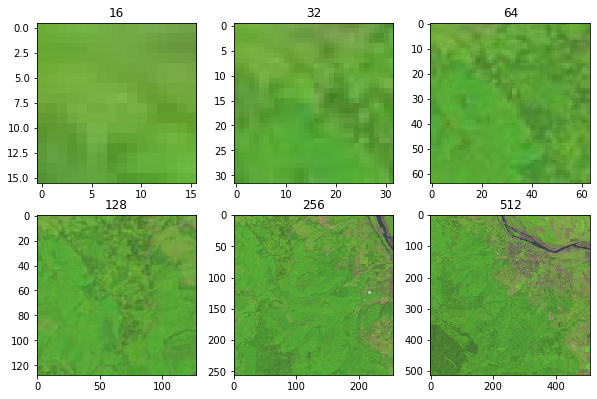

In [14]:
pp.figure(figsize=(10,10))
for i,x in enumerate(range(4,10)):
    pp.subplot(3,3,i+1)
    pp.imshow(satimg[:,:2**x,:2**x].transpose([2,1,0]))
    pp.title(2**x)

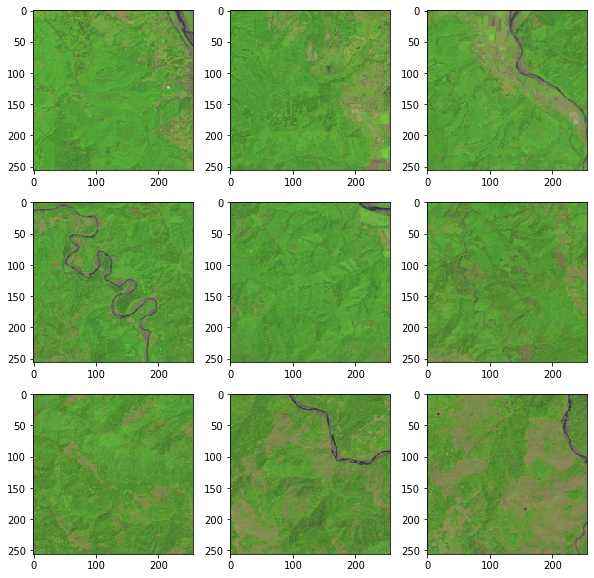

In [15]:
pp.figure(figsize=(10,10))
step = 256
for i in range(1,10):
    pp.subplot(3,3,i)
    pp.imshow(satimg[:, step*(i-1):step*(i), step*(i-1):step*(i)].transpose([2,1,0]))